In [ ]:
import sys
import pandas as pd
pd.options.mode.chained_assignment = None
import numpy as np
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
import time
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model

try:
    import keras as keras_standalone
    keras_version = keras_standalone.__version__
except ImportError:
    keras_version = tf.keras.__version__
print("-" * 40)
print(f"Versión de Python: {sys.version.split(' ')[0]}")
print(f"Versión de TensorFlow: {tf.__version__}")
print(f"Versión de Keras: {keras_version}")
print("-" * 40)

----------------------------------------
Versión de Python: 3.11.5
Versión de TensorFlow: 2.17.0
Versión de Keras: 3.11.3
----------------------------------------


In [ ]:
def calculate_global_metrics(y_test_denorm, y_pred_denorm, start_time, end_time):
    """
    Calculates error metrics and training duration using denormalized data.

    Parameters:
    - y_test_denorm: Denormalized ground truth values (NumPy array).
    - y_pred_denorm: Denormalized predicted values (NumPy array).
    - start_time: Training start timestamp.
    - end_time: Training end timestamp.

    Returns:
    - rmse: Root Mean Squared Error (average across all steps).
    - mae: Mean Absolute Error (average across all steps).
    - mape: Mean Absolute Percentage Error (average across all steps).
    - training_duration: Total training duration in seconds.
    - training_time_str: Formatted duration as HH:MM:SS.
    """
    # 1. Process real values and predictions
    # Flatten arrays to calculate a global metric across all prediction steps (e.g., 24 steps)
    y_true_flat = y_test_denorm.flatten()
    y_pred_flat = y_pred_denorm.flatten()

    # 2. Calculate error metrics
    rmse = np.sqrt(mean_squared_error(y_true_flat, y_pred_flat))
    mae = mean_absolute_error(y_true_flat, y_pred_flat)
    
    # Calculate MAPE, handling potential division by zero
    # Using NumPy to compute the mean of the absolute percentage error
    mape = np.mean(np.abs((y_true_flat - y_pred_flat) / y_true_flat)) * 100

    # 3. Calculate training duration
    training_duration = end_time - start_time
    training_time_str = time.strftime('%H:%M:%S', time.gmtime(training_duration))

    # Print results
    print(f"\n--- Global Denormalized Metrics ---")
    print(f"RMSE (Root Mean Squared Error): {rmse:.4f}")
    print(f"MAE (Mean Absolute Error): {mae:.4f}")
    print(f"MAPE (Mean Absolute Percentage Error): {mape:.2f}%")
    print(f"Training Time: {training_time_str}")

    return rmse, mae, mape, training_duration, training_time_str

In [ ]:
def inspect_model_weights(model):
    """
    Inspects the weights and biases of each layer in a Keras model.

    Parameter:
    - model: Keras/TensorFlow model object.

    Prints:
    - Name, type of each layer, and its weights if they are trainable.
    """
    for i, layer in enumerate(model.layers):
        # Retrieve layer weights and biases
        weights = layer.get_weights()  
        print(f"\n🔹 Layer {i}: {layer.name} ({layer.__class__.__name__})")

        if weights:  # Check if the layer contains trainable parameters
            for j, parameter_block in enumerate(weights):
                print(f"  - Weight Block {j}: {parameter_block.shape}\n{parameter_block}")
        else:
            print("  - ⚠️ This layer does not have trainable weights.")

In [ ]:
def train_val_graph(history, capa_eliminar):
    # Extraer la información de la función objetivo desde el historial de entrenamiento
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']

    # Crear un gráfico con los valores de la función objetivo respecto a las épocas
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, len(train_loss) + 1), train_loss, label='Training Loss')
    plt.plot(range(1, len(val_loss) + 1), val_loss, label='Validation Loss')

    # Ajustar los límites de los ejes
    plt.ylim(0.10, 0.2)
    #plt.xlim(0, 100)

    # Agregar etiquetas y leyenda al gráfico
    plt.title('Training and Validation Loss over Epochs - HL '+str(capa_eliminar)+' deleted')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Mostrar el gráfico
    plt.show()

In [ ]:
# Load the CSV file
data = pd.read_csv("W168H24x2.csv", sep=",")

# 1. Select all rows from the second one onwards (index 1 to end)
rows_to_duplicate = data.iloc[1:]

# 2. Concatenate the original DataFrame with the selected rows (duplicating them)
# Resulting structure: [Row 0] + [Rows 1 to End] + [Rows 1 to End]
extended_data = pd.concat([data, rows_to_duplicate], ignore_index=True)

# 3. Save the new DataFrame to a CSV file
# Output filename reflects the expanded dataset
extended_data.to_csv("W168H24x4.csv", index=False)

print(f"Original DataFrame with {len(data)} rows.")
print(f"Extended DataFrame with {len(extended_data)} rows.")
print("The file 'W168H24x4.csv' has been successfully created.")

DataFrame original con 995521 filas.
DataFrame duplicado con 1991041 filas.
El archivo 'W168H24x4.csv' ha sido creado.


In [ ]:
# Load the CSV file using a comma as the delimiter
data = pd.read_csv("W168H24x2.csv", sep=",")

In [ ]:
# Remove the first column (index 0)
data = data.iloc[:, 1:]

# Separate features (inputs) and labels (outputs)
# First 168 columns are input features, remaining 24 are output labels
X = data.iloc[:, :168].values  
y = data.iloc[:, 168:].values  

# Split the data into training (70%) and testing (30%) sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

# Further split the training set into training and validation (70% - 30%)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.3, random_state=0)

# Convert datasets to float32 for normalization/model compatibility
X_train_norm = X_train.astype('float32')
X_val_norm = X_val.astype('float32')
X_test_norm = X_test.astype('float32')

y_train_norm = y_train.astype('float32')
y_val_norm = y_val.astype('float32')
y_test_norm = y_test.astype('float32')

In [6]:
X_train

array([[0.2856591 , 0.2763865 , 0.2692213 , ..., 0.26735976, 0.26163465,
        0.2644094 ],
       [0.6057392 , 0.60524744, 0.60693336, ..., 0.49776965, 0.4981209 ,
        0.49415195],
       [0.30532822, 0.33117908, 0.33019564, ..., 0.2552773 , 0.25590953,
        0.2652875 ],
       ...,
       [0.89396226, 0.8772435 , 0.8905904 , ..., 0.6113238 , 0.57641107,
        0.5557585 ],
       [0.46763372, 0.48069966, 0.47599313, ..., 0.56857854, 0.58909065,
        0.5901795 ],
       [0.6851884 , 0.6850831 , 0.68726075, ..., 0.61574936, 0.620772  ,
        0.62846404]], dtype=float32)

In [7]:
X_val

array([[0.20578834, 0.20238137, 0.20231113, ..., 0.25144884, 0.2558393 ,
        0.26981843],
       [0.6352429 , 0.63380283, 0.632152  , ..., 0.6002248 , 0.60271853,
        0.5981525 ],
       [0.20273261, 0.20368093, 0.20069544, ..., 0.24231674, 0.2572091 ,
        0.253486  ],
       ...,
       [0.10407081, 0.11934952, 0.10768852, ..., 0.44501424, 0.45010713,
        0.5033894 ],
       [0.50553197, 0.50732327, 0.50641   , ..., 0.566155  , 0.5608514 ,
        0.566998  ],
       [0.23529205, 0.23631063, 0.23434372, ..., 0.16620421, 0.16160303,
        0.15162797]], dtype=float32)

In [8]:
X_test

array([[0.6494679 , 0.65438515, 0.6477468 , ..., 0.5574444 , 0.55481017,
        0.5524569 ],
       [0.7694145 , 0.76604265, 0.75620806, ..., 0.6869797 , 0.6848372 ,
        0.6803414 ],
       [0.3720979 , 0.37680447, 0.39591163, ..., 0.24294896, 0.24052545,
        0.25194058],
       ...,
       [0.44448736, 0.42801446, 0.41466755, ..., 0.23848829, 0.23033965,
        0.23090161],
       [0.59348106, 0.5978364 , 0.61156964, ..., 0.407397  , 0.39952934,
        0.3913807 ],
       [0.50026345, 0.5269573 , 0.554494  , ..., 0.7905237 , 0.77875733,
        0.76246005]], dtype=float32)

In [ ]:
# Model initialization flag: 0 = Load, 1 = Create New
load_model_mode = 0

In [ ]:
# Training hyperparameters
epochs = 300
batch_size = 256
learning_rate = 0.0005 

# Configure Early Stopping to prevent overfitting
early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_loss',         # Metric to monitor (validation loss)
    patience=30,                # Number of epochs with no improvement before stopping
    restore_best_weights=True   # Restore model weights from the epoch with the best value
)

In [ ]:
# Check model initialization flag
if load_model_mode == 1:
    start_time = 0
    # Load existing Keras model
    # model = load_model("WaterDFFNN_MartinDatasetx1_W12.h5", compile=False) 
    model = load_model("Electricityx1.keras")
    
    # Define optimizer with the specific learning rate used originally
    optimizer = keras.optimizers.Adam(epsilon=1e-8, learning_rate=learning_rate) 

    # Re-compile the model for inference or further training
    # 'mae' and 'mse' are standard for regression tasks
    model.compile(optimizer=optimizer, loss='mae', metrics=['mae', 'mse'])
    
    # Perform predictions on the test set
    y_pred = model.predict(X_test_norm)
    print(y_pred)
    end_time = 0

    # Predictions for evaluation
    y_pred = model.predict(X_test_norm)
    y_train_pred = model.predict(X_train_norm)

if load_model_mode == 0:
    # 1. Define the input layer explicitly
    input_layer = keras.Input(shape=(168,))
    x = input_layer
    
    # 2. Add hidden layers
    hidden_units = [60, 60, 60, 60, 60]  # 5 hidden layers with 60 neurons each
    for neurons in hidden_units:
        x = keras.layers.Dense(neurons, activation='tanh')(x)
        
    # 3. Add output layer
    output_layer = keras.layers.Dense(24, activation='tanh')(x)
    
    # 4. Create the Functional API model
    model = keras.Model(inputs=input_layer, outputs=output_layer)
    
    # 5. Define the optimizer
    optimizer = keras.optimizers.Adam(epsilon=1e-8, learning_rate=learning_rate)
    
    # 6. Compile the model with the custom optimizer
    model.compile(optimizer=optimizer, loss='mae', metrics=['mae', 'mse'])
    
    # Model architecture summary
    model.summary()

    # Measure training execution time
    start_time = time.time()
    
    # Train the model
    history = model.fit(
        X_train_norm, 
        y_train_norm, 
        epochs=epochs, 
        batch_size=batch_size, 
        validation_data=(X_val_norm, y_val_norm), 
        callbacks=[early_stopping]
    )
    
    # Capture training end time
    end_time = time.time()

    # Perform predictions for performance analysis
    y_pred = model.predict(X_test_norm)
    y_train_pred = model.predict(X_train_norm)

Model: "functional_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_13 (InputLayer)     │ (None, 168)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_31 (Dense)                │ (None, 60)             │        10,140 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_32 (Dense)                │ (None, 60)             │         3,660 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_33 (Dense)                │ (None, 60)             │         3,660 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_34 (Dense)                │ (None, 60)             │         3,660 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_35 (Dense)                │ (None, 60)             │         3,660 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_36 (Dense)                │ (None, 24)             │         1,464 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 26,244 (102.52 KB)

 Trainable params: 26,244 (102.52 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/300
1906/1906 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - loss: 0.0325 - mae: 0.0325 - mse: 0.0034 - val_loss: 0.0232 - val_mae: 0.0232 - val_mse: 0.0014
Epoch 2/300
1906/1906 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.0221 - mae: 0.0221 - mse: 0.0012 - val_loss: 0.0204 - val_mae: 0.0204 - val_mse: 0.0011
Epoch 3/300
1906/1906 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - loss: 0.0203 - mae: 0.0203 - mse: 9.9940e-04 - val_loss: 0.0194 - val_mae: 0.0194 - val_mse: 9.1909e-04
Epoch 4/300
1906/1906 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - loss: 0.0193 - mae: 0.0193 - mse: 8.7165e-04 - val_loss: 0.0181 - val_mae: 0.0181 - val_mse: 7.8809e-04
Epoch 5/300
1906/1906 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - loss: 0.0188 - mae: 0.0188 - mse: 7.9645e-04 - val_loss: 0.0175 - val_mae: 0.0175 - val_mse: 6.9268e-04
Epoch 6/300
1906/1906 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - loss: 0.0179 - mae: 0.0179 - mse: 7.0977e-04 - val_loss: 0.0180 - val_mae: 0.0180 - val_mse: 7.2342e-04
Epoch 7/300
1906/1906 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/

In [ ]:
# --- Denormalization and Global MAPE Calculation ---
original_data = pd.read_csv('dataset.csv')
min_val = original_data['consumption'].min()
max_val = original_data['consumption'].max()

# Denormalize values (N x 24 Arrays)
y_pred_denorm = y_pred * (max_val - min_val) + min_val
y_test_denorm = y_test * (max_val - min_val) + min_val

# Calculate MAPE with denormalized data (as percentage)
mape_percentage = mean_absolute_percentage_error(y_test_denorm, y_pred_denorm) * 100
print(f"Mean Absolute Percentage Error (MAPE): {mape_percentage:.4f}%")

# Calculate MAE with denormalized data
mae = mean_absolute_error(y_test_denorm, y_pred_denorm)
print(f"Mean Absolute Error (MAE): {mae:.2f}")

# --- MAPE STANDARD DEVIATION CALCULATION ---

# 1. Flatten arrays for point-by-point calculation
y_true_flat = y_test_denorm.flatten()
y_pred_flat = y_pred_denorm.flatten()

# 2. Handle division by zero for APE calculation
# Use a small value (epsilon) to replace zeros in the denominator
epsilon = np.finfo(np.float32).eps 
y_true_for_mape = np.copy(y_true_flat)
y_true_for_mape[y_true_for_mape == 0] = epsilon

# 3. Calculate Absolute Percentage Error (APE) for each data point
absolute_percentage_errors = (np.abs(y_true_flat - y_pred_flat) / y_true_for_mape) * 100

# 4. Calculate MAPE Standard Deviation
std_dev_mape = np.std(absolute_percentage_errors)

# --- Print MAPE Standard Deviation ---
print(f"MAPE Standard Deviation: {std_dev_mape:.3f}%")
print("-" * 35)

# --- Training Duration (Existing logic) ---
# Calculate training duration in seconds
training_duration = end_time - start_time
# Print training time in seconds and HH:MM:SS format
print(f'Training Duration: {training_duration:.2f} seconds')

Mean absolute percentage error (MAPE): 0.9787%
Mean absolute error (MAE): 278.51
Desviación estándar del MAPE): 0.979%
-----------------------------------
Tiempo de entrenamiento: 2016.40 segundos


In [ ]:
# Save the model in the native Keras format
model.save("Electricityx2_5HL.keras")

# Print the final training execution time
# print(f"Training Time: {(end_time - start_time):.2f} seconds")

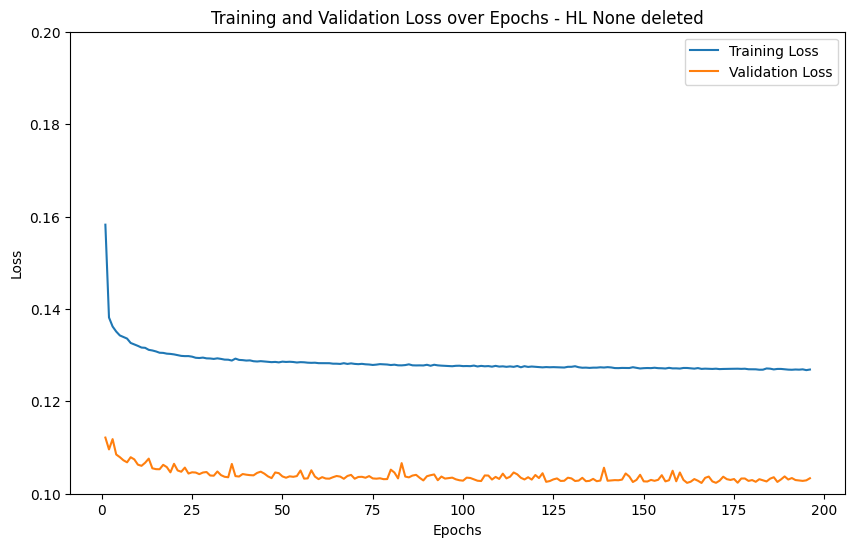

In [ ]:
train_val_graph(history,None)

In [ ]:
# OPTION 1 - BACKWARD STRATEGY (BS)
def backward_strategy_prune(model, target_layer_index):
    """
    Removes a specific hidden layer and reconfigures weights to correctly connect
    adjacent layers. Redirects weights from the pruned layer to the next layer,
    adjusting their size if necessary.
    """
    
    layers = model.layers

    if target_layer_index < 2 or target_layer_index >= len(layers) - 1:
        raise ValueError("The hidden layer index must be between 2 and the total number of hidden layers.")

    print("\n=== STARTING PRUNING PROCESS ===")
    print(f"Target layer index to remove: {target_layer_index}")
    print(f"Total layers in model: {len(layers)}")

    # Involved layers
    previous_layer = layers[target_layer_index - 1]
    layer_to_prune = layers[target_layer_index]
    next_layer = layers[target_layer_index + 1]

    print("\n--- Layers Involved ---")
    print(f"Previous Layer: {previous_layer.name}")
    print(f"Layer to Prune: {layer_to_prune.name}")
    print(f"Next Layer: {next_layer.name}")

    print(f"\nRetrieving weights and biases from target layer: {layer_to_prune.name}")
    print(f"Using '{previous_layer.name}' as reference layer.")

    # Retrieve weights and biases
    input_weights, input_bias = layer_to_prune.get_weights()
    print(f"\nTarget layer weights (shape {input_weights.shape}):\n{input_weights}")
    print(f"Target layer bias:\n{input_bias}")

    ref_weights, ref_bias = previous_layer.get_weights()
    print(f"\nReference layer weights (shape {ref_weights.shape}):\n{ref_weights}")
    print(f"Reference layer bias:\n{ref_bias}")

    num_neurons_prev = input_weights.shape[0]
    num_neurons_prune = input_weights.shape[1]
    num_neurons_next = next_layer.units

    print("\n--- Weight Adjustment ---")
    print(f"Neurons in previous layer: {num_neurons_prev}")
    print(f"Neurons in layer to prune: {num_neurons_prune}")
    print(f"Neurons in next layer: {num_neurons_next}")

    if input_weights.shape[1] > num_neurons_next:
        print("\n------------------------- OPTION 1, BS ----------------------")
        print("\nReducing weights and bias: selecting neurons based on absolute mean similarity.")

        # 1. Target layer means
        origin_means = np.mean(input_weights, axis=0)
        print("\nMean vector (target layer):")
        print(np.round(origin_means, 4))

        # 2. Next layer means
        next_weights, _ = next_layer.get_weights()
        reference_means = np.mean(next_weights, axis=0)
        print("\nMean vector (next layer):")
        print(np.round(reference_means, 4))

        # 3. Select indices of the closest neurons (without repetition)
        selected_indices = []
        used_indices = set()
        for ref_val in reference_means:
            differences = np.abs(origin_means - ref_val)
            sorted_order = np.argsort(differences)
            for idx in sorted_order:
                if idx not in used_indices:
                    selected_indices.append(idx)
                    used_indices.add(idx)
                    break

        print("\nFinal selected indices based on mean similarity:")
        print(selected_indices)

        # 4. Filter weights and biases using selected indices
        input_weights = input_weights[:, selected_indices]
        input_bias = input_bias[selected_indices]

    elif input_weights.shape[1] < num_neurons_next:
        print("\n------- Next layer neuron count is larger; BS not applicable --------")
        return model

    print(f"New weights shape for connecting previous to next layer: {input_weights.shape}")
    print(f"New adjusted bias shape: {input_bias.shape}")

    new_weights = input_weights
    new_bias = input_bias

    # FIXED FOR Keras 3/TF 2.16.1
    # 1. Get model input shape
    full_input_shape = model.input_shape
    
    # 2. Handle multiple inputs (if list)
    if isinstance(full_input_shape, list):
        full_input_shape = full_input_shape[0]
        
    # 3. Extract features dimension (e.g., 12 from (None, 12))
    if isinstance(full_input_shape, tuple):
        input_dim = full_input_shape[-1] 
    else:
        raise ValueError(f"Could not determine model input shape: {full_input_shape}")

    print(f"\n--- Creating new model with input_shape={input_dim} ---")

    inputs = keras.Input(shape=(input_dim,))
    x = inputs

    # Iterate through original model layers to build the new one
    for i, layer in enumerate(layers[1:]): 
        # Skip non-Dense layers
        if not isinstance(layer, keras.layers.Dense):
            continue 
            
        # Skip the pruned layer
        if i + 1 == target_layer_index:
            print(f"Skipping layer: {layer.name}")
            continue
            
        # Reconstruct layer with original attributes
        x = keras.layers.Dense(layer.units, activation=layer.activation, name=layer.name)(x)
        print(f"Adding layer: {layer.name} with {layer.units} units")

    new_model = keras.Model(inputs=inputs, outputs=x)

    print("\n--- Adjusting weights in the new model ---")
    for layer in new_model.layers:
        if isinstance(layer, keras.layers.Dense):
            # 1. Assign the merged weights to the "next" layer
            if layer.name == next_layer.name:
                layer.set_weights([new_weights, new_bias])
                print(f"✅ Assigned adjusted weights to layer: {layer.name}")
            # 2. Copy original weights for all other layers
            else:
                original_layer = next((c for c in model.layers if c.name == layer.name), None)
                if original_layer is not None:
                    layer.set_weights(original_layer.get_weights())
                    print(f"✅ Copied original weights to layer: {layer.name}")

    # Re-compile model with original configuration
    optimizer = keras.optimizers.Adam(epsilon=1e-8, learning_rate=learning_rate)
    new_model.compile(optimizer=optimizer, loss='mae', metrics=['mse', 'mae'])

    print("\n=== PROCESS COMPLETE ===")
    new_model.summary()

    return new_model

In [ ]:
# OPTION 2 - FORWARD STRATEGY (FS)
def forward_strategy_prune(model, target_layer_index):
    import keras
    import numpy as np
    
    layers = model.layers

    if target_layer_index < 1 or target_layer_index >= len(layers) - 1:
        raise ValueError("Index must correspond to a hidden layer (not input or output).")

    print("\n=== STARTING PRUNING PROCESS (FS) ===")

    previous_layer = layers[target_layer_index - 1]
    layer_to_prune = layers[target_layer_index]
    next_layer = layers[target_layer_index + 1]

    print("\n--- Layers Involved ---")
    print(f"Previous Layer: {previous_layer.name}")
    print(f"Layer to Prune: {layer_to_prune.name}")
    print(f"Next Layer: {next_layer.name}")

    # Original weights from the next layer
    next_weights, next_bias = next_layer.get_weights()

    print(f"\nLayer to prune: {layer_to_prune.name}")
    print(f"Next layer: {next_layer.name}")
    print(f"Original next layer weights shape: {next_weights.shape}")

    print(f"\nRetrieving weights and bias from target layer: {layer_to_prune.name}")
    print(f"Using next layer '{next_layer.name}' as reference.")

    input_weights, input_bias = layer_to_prune.get_weights()
    print(f"\nTarget layer weights (shape {input_weights.shape}):\n{input_weights}")
    print(f"Target layer bias:\n{input_bias}")

    ref_weights, ref_bias = next_layer.get_weights()
    print(f"\nReference layer weights (shape {ref_weights.shape}):\n{ref_weights}")
    print(f"Reference layer bias:\n{ref_bias}")

    num_neurons_prev = input_weights.shape[0]
    num_neurons_prune = input_weights.shape[1]
    num_neurons_next = next_layer.units

    print("\n--- Weight Adjustment ---")
    print(f"Neurons in previous layer: {num_neurons_prev}")
    print(f"Neurons in layer to prune: {num_neurons_prune}")
    print(f"Neurons in next layer: {num_neurons_next}")

    # --- CORRECTION 1: Determine new input dimension ---
    if hasattr(previous_layer, "units"):
        # If the previous layer is Dense, use its units
        new_input_dim = previous_layer.units
    else:
        # If previous is InputLayer, use model's input shape
        full_input_shape = model.input_shape
        if isinstance(full_input_shape, list):
            full_input_shape = full_input_shape[0]
        # Extract feature dimension (e.g., 12 from (None, 12))
        new_input_dim = full_input_shape[-1] 
    
    output_neurons = next_layer.units

    print(f"\nAdjusting weights for layer '{next_layer.name}' from {next_weights.shape} → ({new_input_dim}, {output_neurons})")

    if next_weights.shape[0] > new_input_dim:
        print("\n🔻 Row reduction via mean similarity")
        original_means = np.mean(next_weights, axis=1)
        # Generate reference means with uniform spacing
        reference_means = np.linspace(np.min(original_means), np.max(original_means), new_input_dim)

        print("\n▶ Original row means:")
        print(original_means)

        print("\n▶ Generated reference means (uniform spacing):")
        print(reference_means)

        selected_indices = []
        used_indices = set()
        for i, ref in enumerate(reference_means):
            distances = np.abs(original_means - ref)
            sorted_order = np.argsort(distances)
            print(f"\n→ Comparing with reference {i} ({ref:.4f}):")
            print("  Distances:", distances)
            print("  Order:", sorted_order)

            for idx in sorted_order:
                if idx not in used_indices:
                    selected_indices.append(idx)
                    used_indices.add(idx)
                    print(f"  ✅ Selected index {idx} (mean {original_means[idx]:.4f})")
                    break

        print("\n✅ Final indices selected to keep:")
        print(selected_indices)

        # Slice the weights using the selected row indices
        next_weights = next_weights[selected_indices, :]

    elif next_weights.shape[0] < new_input_dim:
        print("\n----------- Next layer has more neurons; FS not applicable -----------")
        return model
        
    print(f"\n✅ Final adjusted weights shape: {next_weights.shape}")

    # --- CORRECTION 2: Get input shape for model reconstruction ---
    full_input_shape = model.input_shape
    if isinstance(full_input_shape, list):
        full_input_shape = full_input_shape[0]
    input_dim = full_input_shape[-1] 
    
    print(f"\n--- Creating new model with input_shape={input_dim} ---")

    inputs = keras.Input(shape=(input_dim,))
    x = inputs

    for i, layer in enumerate(layers[1:]):
        if i + 1 == target_layer_index:
            print(f"Skipping pruned layer: {layer.name}")
            continue
        
        # Ensure only Dense layers are processed
        if not isinstance(layer, keras.layers.Dense):
            continue
            
        x = keras.layers.Dense(layer.units, activation=layer.activation, name=layer.name)(x)

    new_model = keras.Model(inputs=inputs, outputs=x)

    # Assign weights to the new model
    for layer in new_model.layers:
        if isinstance(layer, keras.layers.Dense):
            if layer.name == next_layer.name:
                layer.set_weights([next_weights, next_bias])
                print(f"✅ Assigned new weights to layer: {layer.name}")
            else:
                # Copy original weights for unchanged layers
                original_layer = next((c for c in model.layers if c.name == layer.name), None)
                if original_layer:
                    layer.set_weights(original_layer.get_weights())
                    print(f"✅ Copied original weights to layer: {layer.name}")

    # Recompile with the global learning rate
    optimizer = keras.optimizers.Adam(epsilon=1e-8, learning_rate=learning_rate)
    new_model.compile(optimizer=optimizer, loss='mae', metrics=['mse', 'mae'])

    print("\n=== PROCESS COMPLETE ===")
    new_model.summary()

    return new_model

In [ ]:
# STANDARD PRUNING
def standard_pruning(
    original_model: keras.Model,
    layer_index_to_remove: int,
) -> keras.Model:
    """
    Standard pruning that removes a hidden layer and reconstructs the model.
    Note: This method does not preserve weights for the adjacent layers; 
    it simply defines a new architecture with one less layer.
    """

    # --- 1. Extract configuration and index ---

    # Hidden layers in your model start at index 1 (index 0 is InputLayer)
    hidden_dense_layers = original_model.layers[1:-1]
    
    # The provided hidden layer index is 1-based (1, 2, 3...)
    # For the `hidden_dense_layers` list, we use 0-based indexing, so we subtract 1.
    remove_idx = layer_index_to_remove - 1

    if remove_idx < 0 or remove_idx >= len(hidden_dense_layers):
        print(f"ERROR: Index {layer_index_to_remove} is out of the hidden layer range (1 to {len(hidden_dense_layers)}).")
        return original_model

    # --- 2. Define New Architecture (Layer Pruning) ---

    # Get the unit count for all original hidden layers
    original_hidden_units = [layer.units for layer in hidden_dense_layers]
    
    # Create the new unit list by omitting the selected layer
    reduced_hidden_units = (
        original_hidden_units[:remove_idx] + 
        original_hidden_units[remove_idx+1:]
    )

    print(f"Pruning hidden layer #{layer_index_to_remove} with {original_hidden_units[remove_idx]} units.")
    print(f"New architecture (hidden units): {reduced_hidden_units}")

    # --- 3. Model Reconstruction ---

    # Extract input shape and the original output layer activation
    input_shape = original_model.input_shape[1:]
    output_activation = original_model.layers[-1].activation.__name__
    
    input_layer = keras.Input(shape=input_shape)
    x = input_layer

    # Add reduced hidden layers
    for units in reduced_hidden_units:
        # Assuming 'tanh' as the standard activation for hidden layers
        x = keras.layers.Dense(units, activation='tanh')(x)

    # Add output layer
    # Maintains 24 units and the original output activation
    output_layer = keras.layers.Dense(24, activation=output_activation)(x)

    # Create the reduced functional model
    reduced_model = keras.Model(inputs=input_layer, outputs=output_layer)

    # Compile the reduced model
    # Using the global 'learning_rate' variable defined previously
    optimizer = keras.optimizers.Adam(epsilon=1e-8, learning_rate=learning_rate)
    reduced_model.compile(optimizer=optimizer, loss='mae', metrics=['mae', 'mse'])
    
    print("\n--- Reduced Model Summary ---")
    reduced_model.summary()
    print("----------------------------------\n")
    
    return reduced_model

In [ ]:
# Strategy Selection: 1 = Backward, 2 = Forward, 3 = Standard
pruning_strategy = 2  
target_hidden_layer = 4

if pruning_strategy == 1:
    # Option 1: Backward Strategy Pruning (BS)
    model_pruned = backward_strategy_prune(model, target_hidden_layer)
elif pruning_strategy == 2:
    # Option 2: Forward Strategy Pruning (FS)
    model_pruned = forward_strategy_prune(model, target_hidden_layer)
elif pruning_strategy == 3:
    # Option 3: Standard Layer Pruning (Classic)
    model_pruned = standard_pruning(model, target_hidden_layer)


=== INICIO DEL PROCESO ===

--- Capas involucradas ---
Capa antes: dense_2
Capa a eliminar: dense_3
Capa después: dense_4

Capa a eliminar: dense_3
Capa siguiente: dense_4
Forma original de pesos de la capa siguiente: (60, 60)

Obteniendo pesos y bias de la capa a eliminar: dense_3
Usando la capa posterior 'dense_4' como referencia.

Pesos de la capa a eliminar (forma (90, 60)):
[[-0.08882892  0.06672331  0.1106843  ... -0.20323947  0.06148278
   0.2421428 ]
 [ 0.19140379 -0.21269378 -0.09361155 ...  0.22304621  0.17197263
   0.004413  ]
 [ 0.06765034  0.22428113 -0.2594401  ...  0.08092441 -0.23108414
   0.04495906]
 ...
 [ 0.07980245  0.17283972 -0.14182174 ... -0.18219991 -0.06776182
   0.2398633 ]
 [ 0.1251675  -0.20480551 -0.07700592 ... -0.10676853 -0.02044641
  -0.15120286]
 [ 0.04675413  0.06360561  0.07661088 ...  0.12218941  0.00556134
   0.13549331]]
Bias de la capa a eliminar:
[ 2.73897741e-02 -1.60246436e-02  8.16922449e-03  1.95053068e-03
  4.56092320e-02 -3.51369567e-02

In [ ]:
# Inspect the weights of the model before the pruning process
inspect_model_weights(model)


🔹 Capa 0: input_layer_14 (InputLayer)
  - ⚠️ Esta capa no tiene pesos entrenables.

🔹 Capa 1: dense_65 (Dense)
  - Pesos 0: (12, 40)
[[-0.09370826  0.1648086  -0.04056354  0.20126562 -0.01161632 -0.08252753
  -0.29845887 -0.20267463  0.04238677  0.04885807 -0.3260325   0.16161369
   0.22421041  0.19623907  0.03051327 -0.03902812  0.2757984   0.04351014
   0.04160324  0.1769534  -0.259557    0.27386674 -0.13647202  0.24432117
   0.22435176  0.13586353 -0.04853562 -0.20521729  0.12013845 -0.06374133
  -0.02477405  0.02528322 -0.01590031  0.04751011 -0.17829372 -0.22820728
   0.2971012  -0.2446874  -0.05363576 -0.03390842]
 [-0.29390913  0.09263787 -0.33330426 -0.18944603 -0.25264004  0.06865249
   0.26102686 -0.18672867 -0.07013597  0.09645228  0.06126654 -0.10778011
  -0.04747451 -0.22576983  0.1012185   0.02811892 -0.17445968  0.27496547
   0.05527949  0.08184452 -0.17765856  0.11106235 -0.16169366  0.00613702
  -0.3017288   0.14146754  0.33003038  0.2176185   0.01011087 -0.06358144
 

In [ ]:
# Inspect the weights of the model after the pruning process
inspect_model_weights(model_pruned)


🔹 Capa 0: input_layer_5 (InputLayer)
  - ⚠️ Esta capa no tiene pesos entrenables.

🔹 Capa 1: dense_66 (Dense)
  - Pesos 0: (12, 60)
[[-0.20643388  0.01737381 -0.00188578  0.00556127 -0.10054328 -0.2519836
  -0.1667882   0.07135277 -0.17053965  0.1275013   0.04329761  0.08041992
  -0.1192439  -0.11776188 -0.01921184  0.10459366 -0.11548372  0.08950839
   0.1624882  -0.16331919  0.03551297  0.11267059 -0.04133165  0.03294617
   0.13955274  0.12717809 -0.11313774 -0.1067669   0.06422283  0.09431536
  -0.12213927 -0.08069505 -0.21390247 -0.07917381 -0.16724993 -0.14692762
  -0.12473761  0.15342925  0.22386019 -0.08436671 -0.13789415  0.17510635
  -0.14657678  0.07016288 -0.0576023  -0.18092096 -0.12540042 -0.05903937
  -0.21648926  0.10846126 -0.04665549 -0.17362091 -0.19607621  0.17490526
  -0.14085928  0.14255056 -0.01416865 -0.10074482 -0.04997594 -0.01044213]
 [ 0.20612204 -0.06837474  0.16418466  0.11965851 -0.05126453  0.16008167
  -0.22026812 -0.1146555  -0.12831193  0.21519008 -0.

In [ ]:
# Configure Early Stopping for the pruned model (Fine-tuning phase)
early_stopping_pruned = keras.callbacks.EarlyStopping(
    monitor='val_loss',         # Metric to monitor (validation loss)
    patience=15,                # Number of epochs with no improvement before stopping
    restore_best_weights=True   # Restore model weights from the best epoch
)

# Measure fine-tuning execution time
start_time_pruned = time.time()

# Re-train (fine-tune) the pruned model
history_pruned = model_pruned.fit(
    X_train_norm, 
    y_train_norm, 
    epochs=epochs, 
    batch_size=batch_size, 
    validation_data=(X_val_norm, y_val_norm), 
    callbacks=[early_stopping_pruned]
)

# Capture end time for fine-tuning
end_time_pruned = time.time()

# Perform predictions on the test set using the pruned and fine-tuned model
y_pred_pruned = model_pruned.predict(X_test_norm)
# print(y_pred_pruned)

# Perform predictions on the training set for bias analysis
y_train_pred = model_pruned.predict(X_train_norm)
# print(y_train_pred)

Epoch 1/300
953/953 ━━━━━━━━━━━━━━━━━━━━ 12s 8ms/step - loss: 0.0112 - mae: 0.0112 - mse: 2.4409e-04 - val_loss: 0.0109 - val_mae: 0.0109 - val_mse: 2.2497e-04
Epoch 2/300
953/953 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - loss: 0.0111 - mae: 0.0111 - mse: 2.3683e-04 - val_loss: 0.0140 - val_mae: 0.0140 - val_mse: 3.2911e-04
Epoch 3/300
953/953 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - loss: 0.0110 - mae: 0.0110 - mse: 2.3082e-04 - val_loss: 0.0113 - val_mae: 0.0113 - val_mse: 2.4451e-04
Epoch 4/300
953/953 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - loss: 0.0111 - mae: 0.0111 - mse: 2.3360e-04 - val_loss: 0.0109 - val_mae: 0.0109 - val_mse: 2.3356e-04
Epoch 5/300
953/953 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - loss: 0.0111 - mae: 0.0111 - mse: 2.3354e-04 - val_loss: 0.0120 - val_mae: 0.0120 - val_mse: 2.7957e-04
Epoch 6/300
953/953 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - loss: 0.0110 - mae: 0.0110 - mse: 2.3196e-04 - val_loss: 0.0107 - val_mae: 0.0107 - val_mse: 2.1822e-04
Epoch 7/300
953/953 ━━━━━━━━━━━━━━━━━━━━ 7s 7

In [ ]:
# Print the total fine-tuning execution time
# print(f"Total fine-tuning time: {(end_time_pruned - start_time_pruned):.2f} seconds")

Tiempo total de fine-tuning: 439.62 segundos


In [ ]:
# --- Denormalization and Global MAPE Calculation (Pruned Model) ---
original_data = pd.read_csv('dataset.csv')
min_val = original_data['consumption'].min()
max_val = original_data['consumption'].max()

# Denormalize values (N x 24 Arrays)
y_pred_pruned_denorm = y_pred_pruned * (max_val - min_val) + min_val
y_test_denorm = y_test * (max_val - min_val) + min_val

# Calculate MAPE with denormalized data
mape_pruned = mean_absolute_percentage_error(y_test_denorm, y_pred_pruned_denorm) * 100

# --- MAPE STANDARD DEVIATION CALCULATION ---

# 1. Flatten arrays for point-by-point calculation
y_true_flat = y_test_denorm.flatten()
y_pred_flat = y_pred_pruned_denorm.flatten()

# 2. Handle division by zero for APE calculation
epsilon = np.finfo(np.float32).eps 
y_true_for_mape = np.copy(y_true_flat)
y_true_for_mape[y_true_for_mape == 0] = epsilon

# 3. Calculate Absolute Percentage Error (APE) for each data point
absolute_percentage_errors = (np.abs(y_true_flat - y_pred_flat) / y_true_for_mape) * 100

# 4. Calculate MAPE Standard Deviation
std_dev_mape = np.std(absolute_percentage_errors) 

# --- Print Final Results ---

print("-" * 35)

strategy_map = {
    1: "BS (Backward Strategy)",
    2: "FS (Forward Strategy)",
    3: "Standard Pruning"
}
strategy_text = strategy_map.get(pruning_strategy, "Unknown Option")

print(f"Strategy used: {strategy_text}")
print(f"Pruned hidden layer index: {target_hidden_layer}")
print(f"Mean Absolute Percentage Error (MAPE): {mape_pruned:.4f}%")
print(f"MAPE Standard Deviation: {std_dev_mape:.3f}%")
print(f"Total fine-tuning time: {(end_time_pruned - start_time_pruned):.2f} seconds")

# Get the actual number of epochs until Early Stopping triggered
final_epochs = len(history_pruned.history['loss'])
print(f"Epochs used during fine-tuning: {final_epochs}")

Mean absolute percentage error (MAPE): 1.0341%
Desviación estándar del MAPE): 1.018%
-----------------------------------
Se ha usado la opcion FS para eliminar la capa oculta numero 4
Mean Absolute Percentage Error (MAPE): 1.0341%
Tiempo total de fine-tuning: 170.70 segundos
Épocas utilizadas en el fine-tuning: 23


In [ ]:
# FOR LOOP CODE TO ITERATE OVER LAYERS TO BE PRUNED USING 3 METHODOLOGIES

# Indices are 1-based
layers_to_prune = [1, 2, 3, 4, 5]
pruning_strategy = 3  # Fix the methodology
strategy_map = {1: "BS", 2: "FS", 3: "Standard"}
strategy_text = strategy_map.get(pruning_strategy, "Unknown Option")

comparison_results = []

print(f"--- Starting evaluation of {strategy_text} Pruning on {len(layers_to_prune)} layers ---")
print("-" * 60)

# --- Load dataset for denormalization ---
original_data = pd.read_csv('dataset.csv')
min_val = original_data['consumption'].min()
max_val = original_data['consumption'].max()

# --- Experimentation Loop ---

for target_layer in layers_to_prune:
    # Configure Early Stopping for each iteration
    early_stopping_pruned = keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=15,
        restore_best_weights=True
    )
    
    print(f"\n[EXPERIMENT] Pruning hidden layer number: {target_layer} using {strategy_text}")
    
    # Select the pruning strategy
    if pruning_strategy == 1:
        model_pruned = backward_strategy_prune(model, target_layer)
    elif pruning_strategy == 2:
        model_pruned = forward_strategy_prune(model, target_layer)
    elif pruning_strategy == 3:
        model_pruned = standard_pruning(model, target_layer)

    # Fine-tuning the pruned model
    start_time_ft = time.time()
    history_pruned = model_pruned.fit(
        X_train_norm, 
        y_train_norm, 
        epochs=epochs, 
        batch_size=batch_size, 
        validation_data=(X_val_norm, y_val_norm), 
        callbacks=[early_stopping_pruned]
    )
    end_time_ft = time.time()
    
    # Perform predictions on test set
    y_pred_pruned = model_pruned.predict(X_test_norm)

    # --- Denormalization Process (N x 24 Arrays) ---
    y_pred_denorm = y_pred_pruned * (max_val - min_val) + min_val
    y_test_denorm = y_test * (max_val - min_val) + min_val

    # Calculate global MAPE
    mape_pruned = mean_absolute_percentage_error(y_test_denorm, y_pred_denorm) * 100

    # --- MAPE STANDARD DEVIATION CALCULATION ---

    # 1. Flatten arrays for point-by-point error calculation
    y_true_flat = y_test_denorm.flatten()
    y_pred_flat = y_pred_denorm.flatten()

    # 2. Handle division by zero (using epsilon)
    epsilon = np.finfo(np.float32).eps 
    y_true_for_mape = np.copy(y_true_flat)
    y_true_for_mape[y_true_for_mape == 0] = epsilon

    # 3. Calculate Absolute Percentage Error (APE)
    absolute_percentage_errors = (np.abs(y_true_flat - y_pred_flat) / y_true_for_mape) * 100

    # 4. Calculate Standard Deviation
    std_dev_mape = np.std(absolute_percentage_errors) 

    # --- Print Iteration Results ---
    print("-" * 35)
    print(f'Methodology: {strategy_text} | Target Layer: {target_layer}')
    print(f'Mean Absolute Percentage Error (MAPE): {mape_pruned:.4f}%')
    print(f"MAPE Standard Deviation: {std_dev_mape:.3f}%")
    
    ft_duration = end_time_ft - start_time_ft
    print(f"Total fine-tuning time: {ft_duration:.2f} seconds")
    
    final_epochs = len(history_pruned.history['loss'])
    print(f"Epochs used in fine-tuning: {final_epochs}")
    
    # Store results for final summary
    comparison_results.append({
        'strategy': strategy_text,
        'pruned_layer': target_layer,
        'std_dev': std_dev_mape,
        'mape': mape_pruned,
        'duration': ft_duration,
        'epochs': final_epochs
    })
    print("-" * 60)

# --- Final Summary Table ---
print("\n\n=============== FINAL PRUNING SUMMARY BY LAYER ===============")
print(f"{'Layer':<10} | {'MAPE':<12} | {'Std Dev':<12} | {'Time (s)':<10} | {'Epochs':<8}")
print("-" * 65)
for res in comparison_results:
    print(f"#{res['pruned_layer']:<9} | {res['mape']:<11.4f}% | {res['std_dev']:<11.4f}% | {res['duration']:<9.2f} | {res['epochs']:<7}")
print("================================================================")

--- Iniciando evaluación de Standard Pruning en 5 capas ---
------------------------------------------------------------

[EXPERIMENTO] Poda de la capa oculta número: 1 usando Standard
Eliminando la capa oculta #1 con 60 neuronas.
Nueva arquitectura (neuronas): [60, 60, 60, 60]

--- Resumen del Modelo Reducido ---


Model: "functional_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_14 (InputLayer)     │ (None, 168)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_37 (Dense)                │ (None, 60)             │        10,140 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_38 (Dense)                │ (None, 60)             │         3,660 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_39 (Dense)                │ (None, 60)             │         3,660 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_40 (Dense)                │ (None, 60)             │         3,660 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_41 (Dense)                │ (None, 24)             │         1,464 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 22,584 (88.22 KB)

 Trainable params: 22,584 (88.22 KB)

 Non-trainable params: 0 (0.00 B)

----------------------------------

Epoch 1/300
1906/1906 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - loss: 0.0344 - mae: 0.0344 - mse: 0.0041 - val_loss: 0.0243 - val_mae: 0.0243 - val_mse: 0.0016
Epoch 2/300
1906/1906 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.0230 - mae: 0.0230 - mse: 0.0014 - val_loss: 0.0220 - val_mae: 0.0220 - val_mse: 0.0013
Epoch 3/300
1906/1906 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.0212 - mae: 0.0212 - mse: 0.0012 - val_loss: 0.0253 - val_mae: 0.0253 - val_mse: 0.0013
Epoch 4/300
1906/1906 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.0200 - mae: 0.0200 - mse: 9.8956e-04 - val_loss: 0.0197 - val_mae: 0.0197 - val_mse: 9.3491e-04
Epoch 5/300
1906/1906 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.0191 - mae: 0.0191 - mse: 8.7058e-04 - val_loss: 0.0180 - val_mae: 0.0180 - val_mse: 7.8349e-04
Epoch 6/300
1906/1906 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.0185 - mae: 0.0185 - mse: 7.9559e-04 - val_loss: 0.0177 - val_mae: 0.0177 - val_mse: 7.3719e-04
Epoch 7/300
1906/1906 

Model: "functional_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_15 (InputLayer)     │ (None, 168)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_42 (Dense)                │ (None, 60)             │        10,140 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_43 (Dense)                │ (None, 60)             │         3,660 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_44 (Dense)                │ (None, 60)             │         3,660 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_45 (Dense)                │ (None, 60)             │         3,660 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_46 (Dense)                │ (None, 24)             │         1,464 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 22,584 (88.22 KB)

 Trainable params: 22,584 (88.22 KB)

 Non-trainable params: 0 (0.00 B)

----------------------------------

Epoch 1/300
1906/1906 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - loss: 0.0340 - mae: 0.0340 - mse: 0.0038 - val_loss: 0.0233 - val_mae: 0.0233 - val_mse: 0.0016
Epoch 2/300
1906/1906 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.0228 - mae: 0.0228 - mse: 0.0014 - val_loss: 0.0208 - val_mae: 0.0208 - val_mse: 0.0012
Epoch 3/300
1906/1906 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - loss: 0.0209 - mae: 0.0209 - mse: 0.0012 - val_loss: 0.0195 - val_mae: 0.0195 - val_mse: 0.0010
Epoch 4/300
1906/1906 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.0199 - mae: 0.0199 - mse: 0.0010 - val_loss: 0.0186 - val_mae: 0.0186 - val_mse: 8.9151e-04
Epoch 5/300
1906/1906 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - loss: 0.0190 - mae: 0.0190 - mse: 8.7610e-04 - val_loss: 0.0183 - val_mae: 0.0183 - val_mse: 8.0868e-04
Epoch 6/300
1906/1906 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.0185 - mae: 0.0185 - mse: 7.9617e-04 - val_loss: 0.0179 - val_mae: 0.0179 - val_mse: 7.6942e-04
Epoch 7/300
1906/1906 ━━━━

Model: "functional_16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_16 (InputLayer)     │ (None, 168)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_47 (Dense)                │ (None, 60)             │        10,140 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_48 (Dense)                │ (None, 60)             │         3,660 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_49 (Dense)                │ (None, 60)             │         3,660 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_50 (Dense)                │ (None, 60)             │         3,660 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_51 (Dense)                │ (None, 24)             │         1,464 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 22,584 (88.22 KB)

 Trainable params: 22,584 (88.22 KB)

 Non-trainable params: 0 (0.00 B)

----------------------------------

Epoch 1/300
1906/1906 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - loss: 0.0323 - mae: 0.0323 - mse: 0.0035 - val_loss: 0.0254 - val_mae: 0.0254 - val_mse: 0.0016
Epoch 2/300
1906/1906 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.0223 - mae: 0.0223 - mse: 0.0013 - val_loss: 0.0206 - val_mae: 0.0206 - val_mse: 0.0011
Epoch 3/300
1906/1906 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.0206 - mae: 0.0206 - mse: 0.0011 - val_loss: 0.0208 - val_mae: 0.0208 - val_mse: 9.8200e-04
Epoch 4/300
1906/1906 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.0196 - mae: 0.0196 - mse: 9.1094e-04 - val_loss: 0.0189 - val_mae: 0.0189 - val_mse: 8.5252e-04
Epoch 5/300
1906/1906 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.0188 - mae: 0.0188 - mse: 8.1983e-04 - val_loss: 0.0178 - val_mae: 0.0178 - val_mse: 7.6655e-04
Epoch 6/300
1906/1906 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.0182 - mae: 0.0182 - mse: 7.5855e-04 - val_loss: 0.0173 - val_mae: 0.0173 - val_mse: 6.8309e-04
Epoch 7/300
1906/1

Model: "functional_17"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_17 (InputLayer)     │ (None, 168)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_52 (Dense)                │ (None, 60)             │        10,140 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_53 (Dense)                │ (None, 60)             │         3,660 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_54 (Dense)                │ (None, 60)             │         3,660 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_55 (Dense)                │ (None, 60)             │         3,660 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_56 (Dense)                │ (None, 24)             │         1,464 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 22,584 (88.22 KB)

 Trainable params: 22,584 (88.22 KB)

 Non-trainable params: 0 (0.00 B)

----------------------------------

Epoch 1/300
1906/1906 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - loss: 0.0351 - mae: 0.0351 - mse: 0.0041 - val_loss: 0.0237 - val_mae: 0.0237 - val_mse: 0.0016
Epoch 2/300
1906/1906 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.0229 - mae: 0.0229 - mse: 0.0014 - val_loss: 0.0224 - val_mae: 0.0224 - val_mse: 0.0013
Epoch 3/300
1906/1906 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.0211 - mae: 0.0211 - mse: 0.0011 - val_loss: 0.0194 - val_mae: 0.0194 - val_mse: 9.6942e-04
Epoch 4/300
1906/1906 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.0196 - mae: 0.0196 - mse: 9.3076e-04 - val_loss: 0.0190 - val_mae: 0.0190 - val_mse: 8.5512e-04
Epoch 5/300
1906/1906 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.0190 - mae: 0.0190 - mse: 8.3526e-04 - val_loss: 0.0183 - val_mae: 0.0183 - val_mse: 7.7134e-04
Epoch 6/300
1906/1906 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.0184 - mae: 0.0184 - mse: 7.7290e-04 - val_loss: 0.0176 - val_mae: 0.0176 - val_mse: 7.0745e-04
Epoch 7/300
1906/1

Model: "functional_18"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_18 (InputLayer)     │ (None, 168)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_57 (Dense)                │ (None, 60)             │        10,140 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_58 (Dense)                │ (None, 60)             │         3,660 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_59 (Dense)                │ (None, 60)             │         3,660 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_60 (Dense)                │ (None, 60)             │         3,660 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_61 (Dense)                │ (None, 24)             │         1,464 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 22,584 (88.22 KB)

 Trainable params: 22,584 (88.22 KB)

 Non-trainable params: 0 (0.00 B)

----------------------------------

Epoch 1/300
1906/1906 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - loss: 0.0342 - mae: 0.0342 - mse: 0.0038 - val_loss: 0.0241 - val_mae: 0.0241 - val_mse: 0.0016
Epoch 2/300
1906/1906 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.0229 - mae: 0.0229 - mse: 0.0014 - val_loss: 0.0213 - val_mae: 0.0213 - val_mse: 0.0012
Epoch 3/300
1906/1906 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.0210 - mae: 0.0210 - mse: 0.0011 - val_loss: 0.0195 - val_mae: 0.0195 - val_mse: 9.7794e-04
Epoch 4/300
1906/1906 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.0194 - mae: 0.0194 - mse: 9.1493e-04 - val_loss: 0.0182 - val_mae: 0.0182 - val_mse: 8.1782e-04
Epoch 5/300
1906/1906 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.0188 - mae: 0.0188 - mse: 8.2137e-04 - val_loss: 0.0186 - val_mae: 0.0186 - val_mse: 7.7723e-04
Epoch 6/300
1906/1906 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - loss: 0.0182 - mae: 0.0182 - mse: 7.5237e-04 - val_loss: 0.0180 - val_mae: 0.0180 - val_mse: 7.1213e-04
Epoch 7/300
1906/1

In [ ]:
# Define the filename using strategy and target layer index
# filename = f"PredictionResults/MartinDataset_Methodology-{pruning_strategy}_HiddenLayer-{target_layer}.csv"

# Save results to a CSV file with semicolon as delimiter
# results_pruned.to_csv(filename, sep=";")

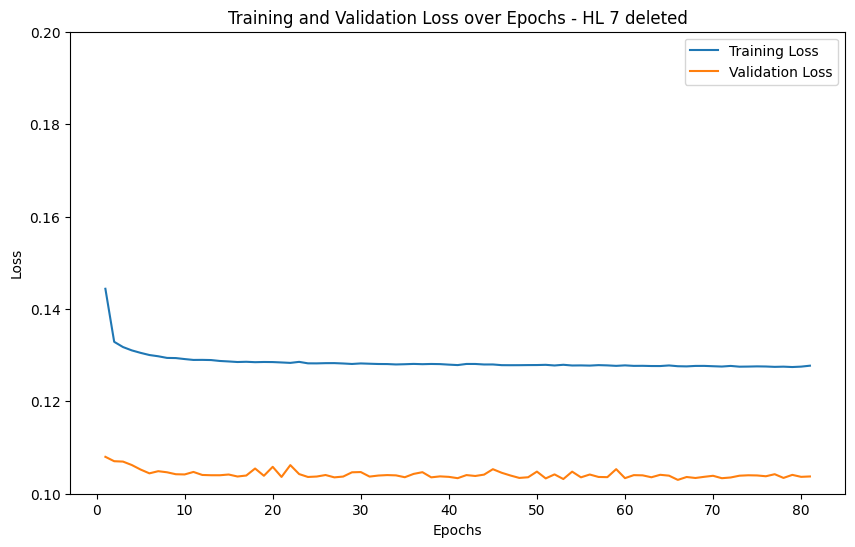

In [ ]:
# Plot training and validation metrics for the pruned model
train_val_graph(history_pruned, target_layer)